# EP2
## Cálculo do Conjunto de Mandelbrot em Paralelo com OMPI e CUDA

Nesse EP temos apenas quatro membros pois um trancou a materia:

| Nome | NUSP |
|------|------|
| Daniel Hotta | 9922700 |
| Matheus Laurentys | 9793714 |
| Pedro Gigeck | 10737136 |
| Rafael Gonçalves | 9009600 |


## Configuração do Ambiente

O ambiente será herdado do EP1

In [2]:
] up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
    Fetching: [========================================>]  99.9 %    Fetching: [========================================>]  100.0 % Resolving package versions...
 Installed ZeroMQ_jll ── v4.3.2+4
 Installed MbedTLS_jll ─ v2.16.6+0
 Installed Parsers ───── v1.0.6
 Installed ZMQ ───────── v1.2.1
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [c8ffd9c3] ↑ MbedTLS_jll v2.16.0+2 ⇒ v2.16.6+0
  [69de0a69] ↑ Parsers v1.0.2 ⇒ v1.0.6
  [c2297ded] ↑ ZMQ v1.2.0 ⇒ v1.2.1
  [8f1865be] ↑ ZeroMQ_jll v4.3.2+2 ⇒ v4.3.2+4


In [3]:
] st

    Status `~/.julia/environments/v1.3/Project.toml`
  [7073ff75] IJulia v1.21.2


## Sobre as Implementações

As implementações com pthreads, OMP e sequencial foram mantidas iguais ao EP1. Estão, respectivamente, em  `mandelbrot_pth.c`, `mandelbrot_omp.c` e `mandelbrot_seq.c`.

A implementação com MPI está em `mandelbrot_omp.c`.

A implementação com CUDA está em  `mandelbrot_cuda.cu`.

Para compilar todas as implementações, basta rodar o Makefile.

In [3]:
; make

make: Nothing to be done for 'all'.


Podemos rodar qualquer uma das implementações para observar as imagens. 

Na versão OMPI, o número de tasks é passado como parâmetro pelo mpirun.

Na versão CUDA, possibilitamos a execução com grids e blocos uni e bidimensionais. 

Para executar com uma dimensão, passe 8 argumentos na linha de comando, sendo os dois últimos os números de blocos e threads por bloco.

Para rodar com grids e blocos bidimensionais, passe 10 argumentos na linha de comando, sendo os 4 últimos as dimensões (x, y) do grid e blocos.

Por exemplo:

In [ ]:
; ./bin/mandelbrot_cuda -2.5 1.5 -2.0 2.0 11500 900 1024


## Determinação Experimental dos Parâmetros

Conforme especificado no enunciado, todas as medições foram feitas com 15 repetições, com o tamanho da imagem 4096 para a região Triple Spiral Valley.

Para medir os tempo de execução, usamos o script `run_measurements.sh`, com o comando `perf`, similar ao EP1.

Todos os resultados já estão na pasta results. O script leva algumas horas e não precisa ser rodado novamente.

In [ ]:
#; ./run_measurements.sh

### CUDA

Para a versão CUDA, os valores experimentados para o grid foram as seguintes combinações de potências de 2:
'4_4' '16_16' '64_64' '256_256' '1024_1024' '2048_2048'

Podemos conferir os resultados nos gráficos gerados abaixo.

  Resolving package versions...


im here
im over


   Updating `/mnt/c/Users/gigec/OneDrive/Área de Trabalho/Pedro/BCC/MAC0219 Paralela/mac-0219/EP2/Project.toml`
 [no changes]
   Updating `/mnt/c/Users/gigec/OneDrive/Área de Trabalho/Pedro/BCC/MAC0219 Paralela/mac-0219/EP2/Manifest.toml`
 [no changes]


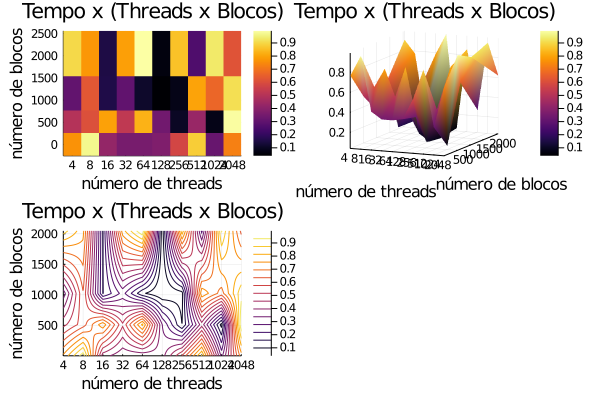

In [18]:
import Pkg
Pkg.add("Plots")
using DataFrames, Plots

# DataFrame to concat all data to write in csv
df_csv = DataFrame()

# ---------- Getting CUDA results ----------

# GPU grid dimensions
# grid_dim = ["4_4" "16_16" "64_64" "256_256" "1024_1024" "2048_2048"]
cuda_blocks = [1, 512, 1024, 2048]
cuda_threads = [2 ^ x for x in 2:11]

# Get the time values from the log file and saves in a string
function get_log_string(dim)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/cuda/triple_spiral_$dim.log`,
          pipeline(`awk '{print $1}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Get the percent values of the error from the log file and saves in a string
function get_log_deviation(dim)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/cuda/triple_spiral_$dim.log`,
          pipeline(`awk '{print $(NF - 1)}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Create a dataframe with values from the log files for all grid sizes
function get_data_frame()
    df = DataFrame()
    #df.sz = [4 ^ x for x in 1:6]
    sz = []
    times = []
    error = []
    for bl in cuda_blocks
        for th in cuda_threads
            dim = string(bl, "_", th)
            print(dim)
            s = get_log_string(dim)
            d = get_log_deviation(dim)
            
            t = parse(Float64, s)
            dv = parse(Float64, chop(d, tail = 2))
            dv = t*dv/100
            
            push!(times, t)
            push!(error, dv)
            push!(sz, bl * th)
        end
    end
    
    df[!, "sz"] = sz
    df[!, "times"] = times
    df[!, "dv"] = error
    df_csv[!, "cuda.sz"] = sz
    df_csv[!, "cuda.times"] = times
    df_csv[!, "cuda.DP"] = error
    return df
end

function plot_data_frame(df)
    xs = df.sz
    ys = df.times
    deviation = df.dv
    plot(xs, ys, yerror = deviation, label = "Tempo de execução total", xlabel = "Blocos x Threads", 
         ylabel = "Tempo (s)", title = "Tempo x Total de Threads\nImplementação CUDA\n")
end

function plot_heatmap(df)
    #data = df.times
    data = rand(4, 10)
    # ---------------------------- Escolham uma das três opções e depois tira as outras pra ficar maior
    plot(
    heatmap(string.(cuda_threads), # string pra ficar igualmente espaçado no gráfico
            cuda_blocks,
            data,
            xlabel="número de threads", ylabel="número de blocos",
            title="Tempo x (Threads x Blocos)"),
    surface(string.(cuda_threads),
            cuda_blocks,
            data,
            xlabel="número de threads", ylabel="número de blocos",
            title="Tempo x (Threads x Blocos)"),
    contour(string.(cuda_threads),
            cuda_blocks,
            data,
            xlabel="número de threads", ylabel="número de blocos",
            title="Tempo x (Threads x Blocos)"))
end
            
# Plot (time x total_threads) graph
df = get_data_frame()
plot_data_frame(df)
plot_heatmap("coloque aqui o df")
                

O primeiro ponto a ser notado é a estabilidade das execuções. No código, podemos conferir que o desvio padrão das medições está sendo mostrado, porém ele é menor que o ponto na representação gráfica. Nos experimentos, conferimos que o desvio padrão não passa de 1 segundo em nenhuma execução.

Outro resultado muito importante é que o tempo de execução é inversamente proporcional ao número total de threads. Quanto mais threads, mais rápido. Com outras implementações paralelas, observávamos um número de threads que minimizava o tempo de execução, geralmente 8 ou 16, e quando executado com mais threads, o tempo aumentava.

A principal explicação para esse fenômeno está no hardware. O potencial de computação paralela de uma GPU, que pode executar milhares de threads em paralelo, não é comparável com o potencial de uma CPU com 4 ou 8 núcleos.

Com isso, concluímos que os melhores parâmetros para execução do experimento são aqueles que maximizam o total de threads, que é capacidade máxima da GPU, no nosso caso, 2048 blocos com 2048 threads.

Além disso, vemos que a disposição das threads nos blocos e a disposição dos blocos nos grids não interfere no desempenho. O que importa é o total de threads. Podemos inferir isso da disposição dos pontos: pontos com o mesmo número total de threads estão concentrados (próximos), independente se são 16 blocos com 8 threads ou 8 blocos com 16 threads.


## Comparando Implementações

Considerando os melhores parâmetros para cada uma das versões, podemos 

------------------------- Daqui pra baixo eu não mexi -------------------------

In [ ]:
using Pkg
Pkg.add("DataFrames")

using DataFrames

# Build global DataFrame with the I/O and MemAlloc Times
disc = DataFrame()
logs = ["full" "elephant" "seahorse" "triple_spiral"]
for l in logs
    lT = string(l, "T")
    out = Pipe()
    cmd = pipeline(`cat times/$lT.log`, out)
    run(cmd)
    close(out.in)
    s = read(out, String)
    s = split(s, '\n')
    pop!(s)
    v = []
    aux = 0
    for j in s
        if j == "==="
            push!(v, aux)
            aux = 0
        else
            aux += parse(Float64, j)
        end
    end
    disc[!, "$l"] = v
end

In [ ]:
# Plot sequencial graphs

import Pkg
Pkg.add("Plots")
using DataFrames, Plots

# DataFrame to concat all data to write in csv
df_csv = DataFrame()
df_csv.sz = [2 ^ x for x in 4:13]

# Get the time values from the log files and saves in a string
function get_log_string(log)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/mandelbrot_seq/$log.log`,
          pipeline(`awk '{print $1}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Get the percent values of the error from the log files and saves in a string
function get_log_deviation(log)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/mandelbrot_seq/$log.log`,
          pipeline(`awk '{print $(NF - 1)}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Transform the strings of times and error into float arrays
function get_values(values, percent, discount)
    values = split(values, '\n')
    percent = split(percent, '\n')
    pop!(values)
    pop!(percent)
    times = []
    error = []
    for i in 1:length(values)
        t = parse(Float64, replace(values[i], ","=>"."))
        if discount != nothing
            t -= discount[i]
        end
        push!(times, t)
        e = parse(Float64, replace(replace(percent[i], ","=>"."), "%"=>""))
        push!(error, (t*e)/100)
    end
    return times, error
end

# Create a dataframe with values from the 4 log files, discount tells if we discount I/O operations
function get_data_frame(discount)
    df = DataFrame()
    df.sz = [2 ^ x for x in 4:13]
    for l in logs
        s = get_log_string(l)
        d = get_log_deviation(l)
        if discount
            dc = disc["$l"]
        else
            dc = nothing
        end
        times, dv = get_values(s, d, dc)
        df[!, "$l"] = times
        df[!, "dv$l"] = dv
        df_csv[!, "seq_$l.times"] = times
        df_csv[!, "seq_$l.DP"] = dv
    end
    return df
end

function plot_data_frame(df, d)
    xs = df.sz
    ys = [df.full df.elephant df.seahorse df.triple_spiral]
    deviation = [df.dvfull df.dvelephant df.dvseahorse df.dvtriple_spiral]
    plot(xs, ys, label = logs, yerror = deviation, 
         xlabel = "Tamanho da Imagem", ylabel = "Tempo (s)", title = "Tempo x Tamanho\nImplementação Sequencial\n$d")
end

df = get_data_frame(false)
plot_data_frame(df, "Sem desconto de I/O")


In [ ]:
df = get_data_frame(true)
plot_data_frame(df, "Com desconto de I/O")

In [ ]:
# Plot the paralell graphs

using DataFrames, Plots

# Get the time values from the log files and saves in a string
function get_log_string(log, implementation, th)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/mandelbrot_$implementation/$log$th.log`,
          pipeline(`awk '{print $1}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Get the percent values of the error from the log files and saves in a string
function get_log_deviation(log, implementation, th)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/mandelbrot_$implementation/$log$th.log`,
          pipeline(`awk '{print $(NF - 1)}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Get a dataFrame (time x image_size) with data  
function get_data_frame(implementation, image)
    df = DataFrame()
    df.sz = [2 ^ x for x in 4:13]
    th = [2 ^ x for x in 0:5]
    for t in th
        s = get_log_string(image, implementation, string(t))
        d = get_log_deviation(image, implementation, string(t))
        
        dc = disc["$image"]
        
        times, dv = get_values(s, d, dc)
        df[!, "t$t"] = times
        df[!, "dv$t"] = dv
        df_csv[!, "$implementation.$image$t.times"] = times
        df_csv[!, "$implementation.$image$t.DP"] = dv
    end
    return df
end

# Função para plotar o DataFrame
function plot_data_frame(df, i, j)
    xs = df.sz
    ys = [df.t1 df.t2 df.t4 df.t8 df.t16 df.t32]
    deviation = [df.dv1 df.dv2 df.dv4 df.dv8 df.dv16 df.dv32]
    labels = ["1" "2" "4" "8" "16" "32"]
    display(plot(xs, ys, label = labels, yerror = deviation, 
         xlabel = "Tamanho da Imagem", ylabel = "Tempo (s)", title = "Tempo x Tamanho\nImplementação $i - $j"))
end

implementations = ["omp" "pth"]
file = ["triple_spiral","seahorse","elephant","full"]
for i in implementations
    for j in file
        df = get_data_frame(i, j)
        plot_data_frame(df, i, j)
    end
end

In [ ]:
using CSV

CSV.write("data.csv", df_csv)

### Análise da implementação sequencial

Com a implementação sequencial, vemos uma clara diferença entre as regiões do Conjunto de Mandelbrot. 

A geração da imagem completa (full) consome muito menos tempo que as regiões específicas, uma das causas pode ser o grande intervalo de pontos que cada pixel da imagem abrange, causando uma baixa definição e, com isso, menos iterações de cálculo. As regiões específicas, que cobriam subconjuntos de tamanhos semelhantes consumiram tempos parecidos. 

Outra observação interessante é o comportamento quadrático do consumo de tempo em função do tamanho da lateral imagem, o que faz sentido já que calculamos um dado número de iterações para cada pixel.

### Análise geral das implementações paralelas

No entanto,com as implementeções paralelas conseguimos observar que ,aparentemente, o Conjunto de Mandelbrot paralelizado por
pthreads apresenta um menor tempo para o calculo quando temos 8 threads. 

Além disso, fica evidente uma diferença gritante na maneira em que a evolução do tempo para o calculo das imagens se comporta independente do numero de threads involvido, dado a implementação ser por OpenMP e Pthreads, pois os graficos gerados pela implementação OpenMP apresentam um tempo de execução e taxa de crescimento similar para n threads para as regiões pedidas, enquanto ao nos voltarmos para os graficos gerados pela implementação pthreads temos taxas de crescimento para o tempo de execução por numero de threads mais distintas entre si.


### Análise da implementação com *pthreads*

Aparentemente o tempo de execução aumenta ainda que aumentamos o numero de threads, com exceção de quando rodamos
imagens com 8 threads provavelmente pois , assim como ocorreu no miniep anterior, a quantidade de threads acaba 
ficando muito maior que a quantidade de núcleos de processamento da máquina, assim, não temos um ganho real 
dividindo o trabalho, pois ele terá que ser executado nos mesmos núcleos. Todavia ainda vemos que ainda ganhamos tempo se comparado com a execução sequencial e que assim como na execução sequencial a geração da imagem completa(full) é mais rapida de ser calculada.

### Análise da implementação com OpenMP

Como ja foi dito, a implementação por OpenMP apresentam um tempo de execução e taxa de crescimento similar para n threads para as regiões pedidas, todavia apresentam um tempo consideravelmente mais rapido para determinadas imagens com relação a outras, em especial a imagem denominada " full ".

• 2) Qual o impacto das operações de I/O e alocação de memória no tempo de execução?

#### Especificações do ambiente utilizado para geração das imagens 

 - Host bridge: Intel Corporation Xeon E3-1200 v6/7th Gen Core Processor Host Bridge/DRAM Registers 
 
 - PCI bridge: Intel Corporation Xeon E3-1200 v5/E3-1500 v5/6th Gen Core Processor PCIe Controller (x16) (rev 05)
 
 - VGA compatible controller: Intel Corporation Device 591b (rev 04)
 
 - USB controller: Intel Corporation 100 Series/C230 Series Chipset Family USB 3.0 xHCI Controller (rev 31)
  
 - Signal processing controller: Intel Corporation 100 Series/C230 Series Chipset Family Thermal Subsystem (rev 31)
 
 - Communication controller: Intel Corporation 100 Series/C230 Series Chipset Family MEI Controller #1 (rev 31)
 
 - SATA controller: Intel Corporation HM170/QM170 Chipset SATA Controller [AHCI Mode] (rev 31)
 
 - PCI bridge: Intel Corporation 100 Series/C230 Series Chipset Family PCI Express Root Port #3 (rev f1)
 
 - PCI bridge: Intel Corporation 100 Series/C230 Series Chipset Family PCI Express Root Port #4 (rev f1)
 
 - PCI bridge: Intel Corporation 100 Series/C230 Series Chipset Family PCI Express Root Port #9 (rev f1)
 
 - ISA bridge: Intel Corporation HM175 Chipset LPC/eSPI Controller (rev 31)
 
 - Memory controller: Intel Corporation 100 Series/C230 Series Chipset Family Power Management Controller (rev 31)
 
 - SMBus: Intel Corporation 100 Series/C230 Series Chipset Family SMBus (rev 31)
 
 - VGA compatible controller: NVIDIA Corporation GP106M [GeForce GTX 1060 Mobile] (rev a1)
 
 - Network controller: Intel Corporation Wireless 8265 / 8275 (rev 78)
 
 - Ethernet controller: Realtek Semiconductor Co., Ltd. RTL8111/8168/8411 PCI Express Gigabit Ethernet Controller


Na célula abaixo, geramos um DataFrame para visualizar qual a influência de cada função no tempo de execução total do programa.

Ele obtém os dados dos arquivos em results_inter, e mostra, na primeira coluna, a porcentagem de tempo que foi gasta executando apenas os cálculos. Na segunda coluna, a porcentagem de tempo para operações de entrada, saída e alocação de memória. A terceira coluna mostra o tempo gasto com outras operações.

In [ ]:
using DataFrames

function get_df_time(path) 
    overhead = []
    system = []
    open(path) do f
        for i in eachline(f)
            if occursin(r".+[0-9]+.[0-9]+%", i)
                x = split(i)
                tmp = split(x[1], "%")
                push!(overhead, parse(Float64, tmp[1]))
                push!(system, x[5])
            end
        end
    end
    return df = DataFrame(A = overhead, B = system)
end


df = (get_df_time("results_inter/mandelbrot_seq/full.log"))


function get_time(df)
    time = [0.0, 0.0, 0.0]

    for i in eachrow(df)
        if occursin(r".*mandelbrot.*", i[2,])
            time[1] += i[1, ]
        elseif occursin(r".*malloc.*", i[2,]) || occursin(r".*IO.*", i[2,]) 
            time[2] += i[1, ]
        else 
            time[3] += i[1, ]
        end
    end
    return time
end

println(typeof(get_time(df)))


function get_all()
    mandel = ["omp", "pth"]
    logs = ["elephant8", "full8", "seahorse8", "triple_spiral8"]
    
    #mandelbrot
    timeM = []
    
    #IO and malloc
    timeIO = []
    
    #Remain
    timeR = []
    
    files = []
    
    for i in mandel
        for j in logs
            tmp_df = (get_df_time("results_inter/mandelbrot_$i/$j.log"))
            time = get_time(tmp_df)
            push!(timeM, time[1])
            push!(timeIO, time[2])
            push!(timeR, time[3])
            push!(files, "$i/$j")
        end
    end
    
    return df = DataFrame(Mandelbrot = timeM, IOandMalloc = timeIO, Remain = timeR, Files = files)
end

println(get_all())